# reload all module before executing code
%load_ext autoreload
%autoreload 2

# Cleaning the Weekly Rental Data

In [1]:
import pandas as pd
import os, re

In [2]:
pd.set_option("display.max_rows", None)  # Show all rows, default is 10
pd.set_option("display.max_columns", None)  # Show all columns, default is 20

# Download Data

## Scraped Domain Data

In [3]:
# set download path
data_path = "../data/raw/domain/"

# list csv files, make sure they match
csv_files = [file for file in os.listdir(data_path) if re.match(r'rental_listings_\d{4}_\d{2}.csv', file)]

In [4]:
# list of dataframes 
df_list = []

# read each file, extract year and month from filename, add as columns
for file in csv_files:
    match = re.search(r'rental_listings_(\d{4})_(\d{2}).csv', file)
    if match:
        year = match.group(1)
        quarter = match.group(2)
        df = pd.read_csv(os.path.join(data_path, file))
        df['year'] = year
        df['quarter'] = quarter
        df_list.append(df)

# concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

In [5]:
print(df.iloc[-1])

property_id                                                   17537987.0
url                           /5-40-sandwych-wentworth-nsw-2648-17537987
rental_price                                               $320 per week
bedrooms                                                             2.0
bathrooms                                                            1.0
car_spaces                                                           1.0
property_type                                    Apartment / Unit / Flat
land_area                                                            0.0
property_features                                             2, ,1, ,1,
suburb                                                         WENTWORTH
postcode                                                            2648
scraped_date                                         2025-04-25 21:10:55
wayback_url            https://web.archive.org/web/20250425211055/htt...
wayback_time                                       

In [6]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 31268, Columns: 52


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

## Suburb CSV

In [8]:
# import the suburb csv as a new dataframe
suburb_df = pd.read_csv("../data/geo/vic_suburbs_postcodes.csv")

In [9]:
# lowercase suburb names for both dataframes to ensure consistency
suburb_df['suburb'] = suburb_df['suburb'].str.lower()
df['suburb'] = df['suburb'].str.lower()

In [10]:
print(f"Rows: {suburb_df.shape[0]}, Columns: {suburb_df.shape[1]}")

Rows: 3186, Columns: 2


In [11]:
df['suburb'].nunique(), df['postcode'].nunique()

(1031, 512)

We clearly have to check the suburbs for duplicates, typos, and possible records outside of Victoria

# Column Standardisation

Let's begin by standardising the columns

This will include: 

- checking for inconsistent column names across files
- rename columns to snake_case
- drop irrelevant columns

In [12]:
# standardise column names to snake_case
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

In [14]:
# only keep relevant columns
relevant_columns = [
    'property_id','rental_price', 'bedrooms', 'bathrooms', 'car_spaces',
    'property_type', 'land_area', 'property_features', 
    'suburb', 'postcode', 'year', 'quarter',
    'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus',
    'agency_name', 'agent_name', 'appointment_only', 'avg_days_on_market',
    'description', 'family_percentage', 'features_list', 
    'first_listed_date', 'full_address', 'last_sold_date',
    'latitude', 'longitude', 'listing_status', 'long_term_resident', 
    'median_rent_price', 'median_sold_price', 'number_sold',
    'renter_percentage', 'schools', 'single_percentage',
    'state_abbreviation', 'structured_features', 'unit_number', 'updated_date',
    'url'
]

df = df[relevant_columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   rental_price         31265 non-null  object 
 2   bedrooms             30944 non-null  object 
 3   bathrooms            17067 non-null  float64
 4   car_spaces           29156 non-null  float64
 5   property_type        31265 non-null  object 
 6   land_area            17122 non-null  float64
 7   property_features    31240 non-null  object 
 8   suburb               31268 non-null  object 
 9   postcode             31268 non-null  int64  
 10  year                 31268 non-null  object 
 11  quarter              31268 non-null  object 
 12  age_0_to_19          14143 non-null  float64
 13  age_20_to_39         14143 non-null  float64
 14  age_40_to_59         14143 non-null  float64
 15  age_60_plus          14143 non-null 

In [16]:
df['state_abbreviation'].value_counts()

state_abbreviation
vic    14143
Name: count, dtype: int64

## Record Standardisation
Let's standardise our data in the following ways:
- stripping leading/trailing spaces
- lowercasing
- collapse multiple spaces
- remove punctuation 
- standardise abbreviations
- validate against controlled vocabularies


In [17]:
# create a udf to preprocess string columns
def preprocess_string_column(col):
    """
    Preprocess a string column by:
    - stripping leading/trailing spaces
    - collapsing multiple spaces
    - removing punctuation (except for hyphens and apostrophes)
    - lowercasing
    """
    if pd.isna(col):
        return col
    # handle non-string entries
    if not isinstance(col, str):
        col = str(col)
    # strip leading/trailing spaces
    col = col.strip()
    # collapse multiple spaces
    col = re.sub(r'\s+', ' ', col)
    # remove punctuation (except for hyphens and apostrophes)
    col = re.sub(r'[^\w\s\'-]', '', col)
    # lowercase
    col = col.lower()
    return col

In [18]:
# apply string preprocessing to columns with type object except 'property_features'
string_columns = df.select_dtypes(include=['object']).columns.tolist()
string_columns.remove('property_features')  # exclude 'property_features' for now

for col in string_columns:
    df[col] = df[col].apply(preprocess_string_column)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   rental_price         31265 non-null  object 
 2   bedrooms             30944 non-null  object 
 3   bathrooms            17067 non-null  float64
 4   car_spaces           29156 non-null  float64
 5   property_type        31265 non-null  object 
 6   land_area            17122 non-null  float64
 7   property_features    31240 non-null  object 
 8   suburb               31268 non-null  object 
 9   postcode             31268 non-null  int64  
 10  year                 31268 non-null  object 
 11  quarter              31268 non-null  object 
 12  age_0_to_19          14143 non-null  float64
 13  age_20_to_39         14143 non-null  float64
 14  age_40_to_59         14143 non-null  float64
 15  age_60_plus          14143 non-null 

### Suburbs

In [20]:
df['suburb'].nunique(), df['postcode'].nunique()

(1031, 512)

In [21]:
df['suburb'].sort_values().unique()

array(['abbotsford', 'aberfeldie', 'acheron', ..., 'yellingbo', 'yendon',
       'yinnar south'], shape=(1031,), dtype=object)

In [22]:
suburb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   postcode  3186 non-null   int64 
 1   suburb    3186 non-null   object
dtypes: int64(1), object(1)
memory usage: 49.9+ KB


In [23]:
# which entries from suburb_df['suburb'] are not in df['suburb']
suburb_df[~suburb_df['suburb'].isin(df['suburb'])].count()

postcode    2129
suburb      2129
dtype: int64

## Dealing with Missing Values

Let's first inspect the missing values to see if there are any trends

In [24]:
df.isna().sum()

property_id                3
rental_price               3
bedrooms                 324
bathrooms              14201
car_spaces              2112
property_type              3
land_area              14146
property_features         28
suburb                     0
postcode                   0
year                       0
quarter                    0
age_0_to_19            17125
age_20_to_39           17125
age_40_to_59           17125
age_60_plus            17125
agency_name            17125
agent_name             17396
appointment_only       17516
avg_days_on_market     17126
description            17127
family_percentage      17125
features_list          23274
first_listed_date      17125
full_address           17125
last_sold_date         28958
latitude               17125
longitude              17125
listing_status         17125
long_term_resident     17125
median_rent_price      17126
median_sold_price      17126
number_sold            17125
renter_percentage      17125
schools       

First of all, having rental_price is essential; drop the records without this value

In [25]:
# drop rows where rental_price is missing
df = df.dropna(subset=['rental_price'])

In [26]:
df.shape

(31265, 41)

In [27]:
# convert property_id to int
df['property_id'] = df['property_id'].astype(int)

In [28]:
df['property_id'].nunique()

29333

We see that there are duplicate listing records for the same property. We remove these duplicates by picking the listing with the most recent (year, quarter).

In [29]:
# sort df by (year, quarter) descending
df = df.sort_values(by=['year', 'quarter'], ascending=False)
# drop duplicates
df = df.drop_duplicates(subset=['property_id'])
df.shape

(29333, 41)

In [30]:
# Convert the columns latitude and longitude to a Point (only if latitude and longitude are not null), call the column coordinates 
# drop latitude and longitude columns
from shapely.geometry import Point

df['coordinates'] = df[['latitude', 'longitude']].apply(lambda x: Point(x['latitude'], x['longitude']) if not pd.isna(x['latitude']) and not pd.isna(x['longitude']) else None, axis=1)
df = df.drop(columns=['latitude', 'longitude'])

In [31]:
# Import the GeoUtils class from utils/geo.py
from utils.geo import GeoUtils

# Initialize GeoUtils 
geoutils = GeoUtils()

# create a mask where full address is null 
mask = df['full_address'].isna()

# extracting full address from url for the wayback listings
df.loc[mask, 'full_address'] = df.loc[mask, 'url'].apply(geoutils.extract_address_from_url)


OpenRouteService client initialized successfully.


In [32]:
df['full_address'].isna().sum()

np.int64(0)

### Dealing with missing coordinates 

In [33]:
df['coordinates'].isna().sum()

np.int64(15190)

There are 15190 listings without coordinates. We first use the nominatim geocoding API which has no request limit. This takes a very long time to run and the results have been saved to `data/processed/domain/rental_listings_summary_cleaned.csv`. We load in the results. 

In [34]:
# geocoded results from nominatim API
df_tmp = pd.read_csv('../data/processed/domain/rental_listings_summary_cleaned.csv')

mask = df['coordinates'].isna()
coordinate_mapping = df_tmp.set_index('property_id')['coordinates'].to_dict()
df.loc[mask, 'coordinates'] = df.loc[mask, 'property_id'].map(coordinate_mapping)


In [35]:
df['coordinates'].isna().sum()


np.int64(3856)

We see that there are still 3856 listings without coordinates, these listings had null values from Nominatim API. A more robust geocoding API is using the ORS geocoding API. For the remaining 3856 records, we call ORS geocoding API. But this API has a limit of 500 calls per API key per day.

In [36]:
# Saving the properties that we need to geocode with ORS API
mask = df['coordinates'].isna()
#make directory if it doesn't exist
os.makedirs('../data/raw/missing_geo/', exist_ok=True)
df.loc[mask][['property_id', 'full_address']].to_csv('../data/raw/missing_geo/rental_listings_missing_coordinates.csv', index=False)

Now we will run a python script that reads in `rental_listings_missing_coordinates.csv`, batches it into 500 and calls the ORS API.

In [37]:
df['coordinates'].isna().sum()

np.int64(3856)

In [38]:
df.loc[mask, 'property_id'].map(coordinate_mapping)

27908    NaN
27909    NaN
27910    NaN
27911    NaN
27912    NaN
27913    NaN
27914    NaN
27915    NaN
27916    NaN
27917    NaN
27918    NaN
27919    NaN
27920    NaN
27921    NaN
27922    NaN
27923    NaN
27924    NaN
27925    NaN
27926    NaN
27927    NaN
6429     NaN
6430     NaN
6431     NaN
6432     NaN
6433     NaN
6434     NaN
6435     NaN
6436     NaN
6437     NaN
6438     NaN
6439     NaN
6440     NaN
6441     NaN
6442     NaN
6443     NaN
6444     NaN
6445     NaN
6446     NaN
6447     NaN
6448     NaN
6449     NaN
6450     NaN
6451     NaN
6452     NaN
6453     NaN
6454     NaN
6455     NaN
6456     NaN
6457     NaN
6458     NaN
6459     NaN
6460     NaN
6461     NaN
6462     NaN
6463     NaN
6464     NaN
6465     NaN
6466     NaN
6467     NaN
6468     NaN
6469     NaN
6470     NaN
6471     NaN
6472     NaN
6473     NaN
6474     NaN
6475     NaN
6476     NaN
6477     NaN
6478     NaN
6479     NaN
6480     NaN
6481     NaN
6482     NaN
6483     NaN
6484     NaN
6485     NaN

### Clean and Convert Key Fields

We need to clean and convert columns to be more standardised and easier to analyse

Let's start with the rental_price.



First, let's remove '$' and ',' from the values

In [39]:
# remove '$' and ',' from rental_price 
df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_59480/641504744.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)


Convert to lower casing to remove some duplicates

In [40]:
df["rental_price"] = df["rental_price"].str.lower()

There are a number of values in which we do not want

In [41]:
# remove spaces in rental_price
df['rental_price'] = df['rental_price'].str.replace(' ', '')

In [42]:
# keep records which start with a number
df = df[df['rental_price'].str.match(r'^\d')]

In [43]:
print(df['rental_price'].value_counts().sort_values())

rental_price
290pw-savetimeviewour3dtourapply                1
140000perweek                                   1
480perweekavailablenow                          1
1700weekly                                      1
102000                                          1
88500                                           1
1295                                            1
480perweek-2086percalendarmonth                 1
670perweekinclutilities                         1
360perweek-unfurnished                          1
696perweek                                      1
335weekly                                       1
50                                              1
525perweekpw                                    1
870pw                                           1
420pw-savetimeviewour3dtourapply                1
450w                                            1
30wk                                            1
27perweek                                       1
22perweek                            

In [44]:
# extract numeric value from rental_price (based on the first number found)
df['price_value'] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)

We also need a column to see if the rent is by weekly or monthly payments

In [45]:
freq_keywords = [
    'pw', 'perweek', 'weekly', 'p/w', 'wk', 'p.w.',
    '/wk', '/w', '/week', 'p.w',
    'permonth', 'pm', 'calendar', 'monthly', 'calender',
    'percalendarmonth', 'percalendermonth'
    ]

In [46]:
# Extract frequency keyword after the number
df["price_frequency"] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)+(" + "|".join(freq_keywords) + ")", expand=False)[1]

In [47]:
# Map known patterns to standardized categories
df["price_frequency"] = df["price_frequency"].map({
    "pw": "weekly",
    "p.w.": "weekly",
    "perweek": "weekly",
    "weekly": "weekly",
    "p/w": "weekly",
    "wk": "weekly",
    "p.w": "weekly",
    "/wk": "weekly",
    "/w": "weekly",
    "/week": "weekly",
    "pm": "monthly",
    "permonth": "monthly",
    "calendar": "monthly",
    "calender": "monthly",
    "monthly": "monthly",
    "percalendarmonth": "monthly",
    "percalendermonth": "monthly"
})

In [48]:
# If price is purely numeric (digits and full stops), assume weekly
numeric_mask = df["rental_price"].str.match(r"^[\d\.]+$")
df.loc[numeric_mask & df["price_frequency"].isna(), "price_frequency"] = "weekly"

# Assign 'unknown' to unmatched entries
df["price_frequency"] = df["price_frequency"].fillna("unknown")

# Convert to categorical type
df["price_frequency"] = pd.Categorical(df["price_frequency"], categories=["weekly", "monthly", "unknown"])

In [49]:
df['price_frequency'].value_counts()

price_frequency
weekly     28766
unknown       87
monthly       66
Name: count, dtype: int64

In [50]:
df[df['price_frequency'] == 'unknown']['rental_price'].value_counts().sort_values()

rental_price
25000paavailablenow                    1
950week                                1
250month                               1
850week                                1
75wcarpark                             1
650tojuly2025                          1
250wallbillsincludedinrent             1
1380week                               1
325weekac1412pcm                       1
39000paoutgoings                       1
52000perannumplusgst                   1
720incbillsperweek                     1
750week                                1
170to240                               1
1400week                               1
570-fullyfurnished                     1
900includesbillsperweek                1
2384percalandarmonth                   1
520-perweek-fullyfurnished             1
340weekfullyfurnished                  1
809to889                               1
680andfullyfurnishedoptionatextrapw    1
600onhold                              1
1950pcmincludinggst                    1
950

In [51]:
# drop unknown price_frequency
df = df[df['price_frequency'] != 'unknown']

Now that we have a column for the actual price and a column for frequency, let's now calculate the weekly price and replace the rental price with that

In [52]:
# Create weekly_rent based on price_frequency
df["weekly_rent"] = df.apply(
    lambda row: row["price_value"] if row["price_frequency"] == "weekly"
    else row["price_value"] / 4 if row["price_frequency"] == "monthly"
    else None,
    axis=1
)

# Drop original columns
df = df.drop(columns=["rental_price", "price_value", "price_frequency"])


In [53]:
df["weekly_rent"].describe()

count    2.883200e+04
mean     6.924642e+03
std      5.663043e+04
min      1.800000e+01
25%      4.700000e+02
50%      5.700000e+02
75%      7.300000e+02
max      5.302303e+06
Name: weekly_rent, dtype: float64

Let's first deal with the outliers using IQR

In [54]:
import numpy as np
import math as m

# Removing the outliers
def removeOutliers(dataframe, columns):
    """
    Detects and treats outliers using IQR for multiple variables in a DataFrame.
    :param dataframe: The input DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param n: number of records in the dataframe
    :param factor: The IQR factor to use for detecting outliers
    :return: The processed DataFrame with outliers treated
    """

    # calculate the factor based on the number of records
    factor = m.sqrt(np.log(len(dataframe))) - 0.5

    # iterate through each column to treat outliers
    for col in columns:
        # calculate Q1, Q3, and IQR
        Q3 = np.quantile(dataframe[col], 0.75)
        Q1 = np.quantile(dataframe[col], 0.25)
        IQR = Q3 - Q1

        print("IQR value for column %s is: %s" % (col, IQR))

        # determine the lower and upper range for outliers
        lower_range = Q1 - factor * IQR
        upper_range = Q3 + factor * IQR
        
        # filter dataframe to keep only rows within the IQR range
        dataframe = dataframe[(dataframe[col] >= lower_range) & (dataframe[col] <= upper_range)]
        print("After treating outliers, shape of data is: ", dataframe.shape)
    
    return dataframe

In [55]:
df = removeOutliers(df, ['weekly_rent'])

IQR value for column weekly_rent is: 260.0
After treating outliers, shape of data is:  (25714, 40)


Text(0.5, 1.0, 'Distribution of Weekly Rent Prices')

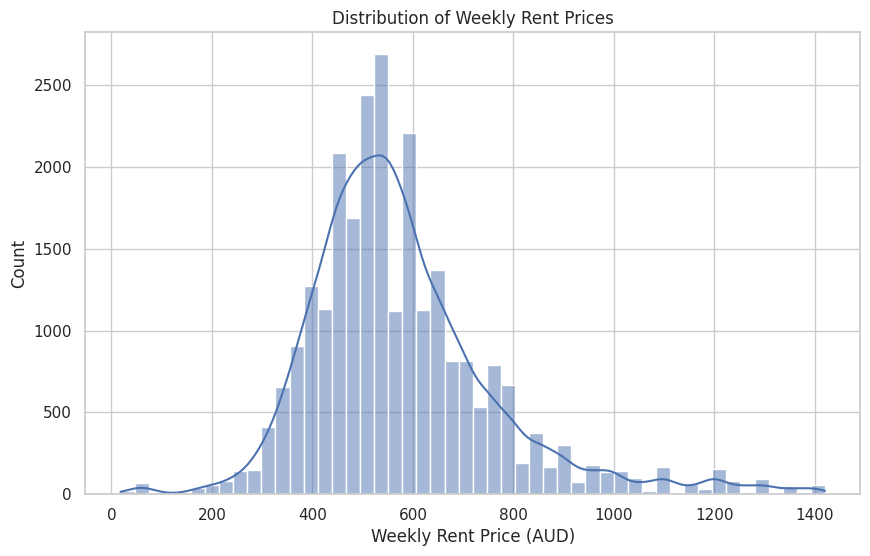

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["weekly_rent"], bins=50, kde=True)

# Add labels and title
plt.xlabel("Weekly Rent Price (AUD)")
plt.ylabel("Count")
plt.title("Distribution of Weekly Rent Prices")

In [57]:
# save intermediate df result
saved_df = df.copy()

In [58]:
saved_df.shape

(25714, 40)

In [59]:
saved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25714 entries, 10077 to 24952
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          25714 non-null  int64  
 1   bedrooms             25485 non-null  object 
 2   bathrooms            12039 non-null  float64
 3   car_spaces           24257 non-null  float64
 4   property_type        25714 non-null  object 
 5   land_area            12045 non-null  float64
 6   property_features    25696 non-null  object 
 7   suburb               25714 non-null  object 
 8   postcode             25714 non-null  int64  
 9   year                 25714 non-null  object 
 10  quarter              25714 non-null  object 
 11  age_0_to_19          13669 non-null  float64
 12  age_20_to_39         13669 non-null  float64
 13  age_40_to_59         13669 non-null  float64
 14  age_60_plus          13669 non-null  float64
 15  agency_name          13669 non-null  

In [60]:
# save intermediate df result
# make directory if it doesn't exist
os.makedirs("../data/curated/rent_features/", exist_ok=True)
saved_df.to_csv("../data/curated/rent_features/cleaned_listings.csv")

After removing outliers, there are now 2854 listings with missing coordinates.

In [61]:
saved_df['coordinates'].isna().sum()

np.int64(2854)

In [62]:
# Saving the properties that we need to geocode with ORS API
mask = saved_df['coordinates'].isna()
# make directory if it doesn't exist
os.makedirs('../data/raw/missing_geo/', exist_ok=True)
saved_df.loc[mask][['property_id', 'full_address']].to_csv('../data/raw/missing_geo/rental_listings_missing_coordinates.csv', index=False)

## Cleaning Property Features

In order to answer question 2: Forecasting Rent Growth for suburbs, we need to match our scraped data's categories with provided ones from the ABS website.

The ABS dataset is aggregated by number of bedrooms and property type(1-3 for flats and 1-4 for houses), as well as a separate sheet for the grand total median over suburbs.

We will match that formatting with our scraped data by creating a new dataframe with each suburb as a record, and type of property + number of bedrooms for its columns. Each entry will be the median price of that combination.

### Number of Bedrooms

In [63]:
# find records where 'bedrooms' is missing and 'property_features' doesn't have digits
missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]

# drop rows where bedrooms is missing and 'property_features' doesn't have digits
df = df.drop(missing_bedrooms_features.index)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_59480/3890117457.py:2: SyntaxWarning: invalid escape sequence '\d'
  missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]


In [64]:
# drop rows where property_features that do not start with a digit and bedrooms is missing
df_no_digit = df[df['property_features'].str.match(r'^\D', na=False)]
df_no_digit = df_no_digit[df_no_digit['bedrooms'].isnull()]
df = df.drop(df_no_digit.index)

WARNING: something weird going on here. 

In [65]:
# see if 'bedrooms' matches the first number in 'property_features'
bedroom_pattern = r'\b(\d+),'
df['extracted_bedrooms'] = df['property_features'].str.extract(bedroom_pattern, flags=re.IGNORECASE)[0].astype(float)

# remove records where 'bedrooms' is missing and 'extracted_bedrooms' is also missing
df = df[~(df['bedrooms'].isnull() & df['extracted_bedrooms'].isnull())]

In [66]:
df.head()

,property_id,bedrooms,bathrooms,car_spaces,property_type,land_area,property_features,suburb,postcode,year,quarter,age_0_to_19,age_20_to_39,age_40_to_59,age_60_plus,agency_name,agent_name,appointment_only,avg_days_on_market,description,family_percentage,features_list,first_listed_date,full_address,last_sold_date,listing_status,long_term_resident,median_rent_price,median_sold_price,number_sold,renter_percentage,schools,single_percentage,state_abbreviation,structured_features,unit_number,updated_date,url,coordinates,weekly_rent,extracted_bedrooms
10077,17732837,3,NaN,2.0,townhouse,NaN,"3, ,2, ,2,",abbotsford,3067,2025,09,0.142523,0.500000,0.226636,0.130841,rt edgar - northside,lily passarelli,false,60.0,just freshly painted throughout with new winpl...,0.530435,split system air consplit system heatinginterc...,2025-08-26t16142051,14 federation lane abbotsford vic 3067,NaN,live,0.422096,900.0,1350000.0,34.0,0.410405,'clifton hill primary school' 'government' 'pr...,0.469565,vic,'name' 'bath' 'category' 'indoor' 'source' 'su...,NaN,2025-09-03t10121796,httpswwwdomaincomau14-federation-lane-abbotsfo...,POINT (-37.796893 144.9961565),880.0,3.0
10078,17744154,2,NaN,2.0,apartment unit flat,NaN,"2, ,2, ,1,",abbotsford,3067,2025,09,0.084168,0.640712,0.200222,0.074898,fletchers projects rental,joyee jiang,false,69.0,perfectly positioned in the heart of abbotsfor...,0.496448,NaN,2025-09-02t174523157,106609 victoria street abbotsford vic 3067,NaN,live,0.441558,660.0,580000.0,187.0,0.737643,'yarra primary school' 'government' 'primary' ...,0.503552,vic,'name' 'gas' 'category' 'indoor' 'source' 'sug...,106,2025-09-02t17452316,httpswwwdomaincomau106-609-victoria-street-abb...,POINT (-37.8110653 145.0076834),750.0,2.0
10079,17750349,1,NaN,1.0,apartment unit flat,NaN,"1, ,1, ,1,",abbotsford,3067,2025,09,0.123570,0.334096,0.235698,0.306636,rentbetter,NaN,true,85.0,property id 399933 quote when calling apply he...,0.406250,air conditioningbalcony deckbuilt-in wardrobe...,2025-09-06t225353913,abbotsford vic 3067,NaN,live,0.491228,510.0,393000.0,141.0,0.585526,'sophia mundi steiner school' 'private' 'combi...,0.593750,vic,'name' 'internal laundry' 'category' 'indoor' ...,NaN,2025-09-06t225353917,httpswwwdomaincomauabbotsford-vic-3067-17750349,POINT (-37.80210950000001 145.0019064),630.0,1.0
10080,17739910,2,NaN,1.0,townhouse,NaN,"2, ,1, ,1,",abbotsford,3067,2025,09,0.174757,0.508091,0.220065,0.097087,miles real estate ivanhoe,carly tomat,false,32.0,first inspections hoping to be set for saturda...,0.449219,air conditioningoutdoor entertainment areabuil...,2025-09-01t10375424,42 princes street abbotsford vic 3067,NaN,recentlyupdated,0.558935,725.0,1100000.0,42.0,0.504425,'abbotsford primary school' 'government' 'prim...,0.550781,vic,'name' 'internal laundry' 'category' 'indoor' ...,4,2025-09-11t170052007,httpswwwdomaincomau4-2-princes-street-abbotsfo...,POINT (-37.8092053 144.999856),650.0,2.0
10081,17751219,2,NaN,1.0,house,NaN,"2, ,1, ,−,",abbotsford,3067,2025,09,0.170111,0.400636,0.275040,0.154213,jellis craig richmond surrounds,nathan roberts,false,32.0,discover this spacious and beautifully appoint...,0.438492,air conditioninggarden courtyardfully fencedb...,2025-09-08t12314526,45 park st abbotsford vic 3067,NaN,new,0.471483,725.0,1100000.0,42.0,0.392857,'abbotsford primary school' 'government' 'prim...,0.561508,vic,'name' 'gas' 'category' 'indoor' 'source' 'sug...,NaN,2025-09-11t092517693,httpswwwdomaincomau45-park-st-abbotsford-vic-3...,POINT (-37.8080424 144.9939399),750.0,2.0


In [67]:
# remove records where 'extracted_bedrooms' is missing
# all these records are acreage or land
df = df[~df['extracted_bedrooms'].isnull()]

In [68]:
# convert 'extracted_bedrooms' to int
df['extracted_bedrooms'] = df['extracted_bedrooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)

In [69]:
# how many records have mismatched bedrooms and extracted_bedrooms
df[df['bedrooms'] != df['extracted_bedrooms']].shape[0]

11751

In [70]:
# TODO : replace 'bedrooms' with 'exracted_bedrooms'
df['bedrooms'] = df['extracted_bedrooms']
df = df.drop(columns=['extracted_bedrooms'])

In [71]:
# how many records with missing bedrooms now
df['bedrooms'].isnull().sum()

np.int64(0)

In [72]:
df['bedrooms'].value_counts().sort_index()

bedrooms
1     3302
2     7075
3     8854
4     5711
5      458
6       49
7       13
8        6
9        6
11       1
50       1
Name: count, dtype: int64

### Property Type


Let's begin by seeing what property types we are given

In [73]:
df['property_type'].value_counts()

property_type
house                           13794
apartment  unit  flat            8701
townhouse                        2554
studio                            233
villa                              65
new apartments  off the plan       52
acreage  semi-rural                14
semi-detached                      14
new house  land                    12
terrace                            11
duplex                             10
block of units                      7
carspace                            3
rural                               3
vacant land                         2
penthouse                           1
Name: count, dtype: int64

In [74]:
df['property_type'].isnull().sum()

np.int64(0)

We need to match non house or flat properties to either house or flat

We also need to drop property types which are not 'renter-friendly', or fall out of the two categories' range

The following will be mapped to **House**
- House
- Townhouse
- Villa
- New House & Land
- Semi-Detached
- Terrace
- Duplex

The following will be mapped to **Flat**
- Apartment / Unit / Flat
- Studio
- New Apartments / Off the Plan
- Penthouse

The following will be dropped
- Vacant Land
- Carspace
- Block of Units
- Acreage / Semi-rural
- Rural

In [75]:
# drop rows with not permitted property_type
permitted_types = ["house", "new house & land", "townhouse", "villa", "semi-detached", "terrace", "duplex",
                   "apartment / unit / flat", "studio", "new apartments / off the plan", "penthouse",
                   ]

df = df[df['property_type'].isin(permitted_types)]

Let's begin with cleaning property_type

In [76]:
# convert 'property_type' to lowercase and strip spaces
df['property_type'] = df['property_type'].str.lower()

In [77]:
# create a mapping dictionary
property_type_mapping = {
    "house": ["house", "new house land", "townhouse", "villa", "semi-detached", "terrace", "duplex", ],
    "flat": ["apartment unit flat", "studio", "new apartments off the plan", "penthouse"]
}

In [78]:
# create a new column 'house_flat_other' based on the mapping
df["house_flat_other"] = df["property_type"].apply(
    lambda x: next((key for key, values in property_type_mapping.items() if x in values), "unknown")
)

In [79]:
df['house_flat_other'].value_counts()

house_flat_other
house    16448
flat       234
Name: count, dtype: int64

### Combine and Create New Dataframe

We now want to create and save a new dataframe for each bedroom and property type combo.

Within each csv:
- records will be suburb
- columns will be year and quarter in chronological order
- value will be the median rent

We will do this using pivoted median aggregation

In [80]:
# first convert 'quarter' to numeric
df['quarter'] = pd.to_numeric(df['quarter'], errors='coerce')

# turn 'quarter' into 1, 2, 3, 4
df['quarter'] = ((df['quarter'] - 1) // 3 + 1).astype(int)

In [81]:
# remove previously saved files
from pathlib import Path
for path in Path("../data/curated/rent_growth/").glob("[0-9]* bedroom*.csv"):
    path.unlink()

In [82]:
import pandas as pd

# Step 1: Create 'bedroom_type' and 'year_quarter' columns
df["bedroom_type"] = df["bedrooms"].astype(str) + " bedroom " + df["house_flat_other"]
df["year_quarter"] = df["year"].astype(str) + "_Q" + (df["quarter"]).astype(str)

# Step 2: Loop through each bedroom_type
for btype in df["bedroom_type"].unique():
    subset = df[df["bedroom_type"] == btype]

    # Step 3: Group and aggregate median rent
    grouped = subset.groupby(["suburb", "year_quarter"])["weekly_rent"].median().reset_index()

    # Step 4: Pivot to wide format
    pivoted = grouped.pivot(index="suburb", columns="year_quarter", values="weekly_rent")

    # Step 5: Save to CSV
    os.makedirs("../data/curated/rent_growth/", exist_ok=True)
    filepath = os.path.join("../data/curated/rent_growth/", f"{btype}.csv")
    pivoted.to_csv(filepath)


# Numeric Columns

Let's have a look at all the numeric columns and decide which ones to keep

In [83]:
# preprocess the numeric columns of df
numeric_df = df.select_dtypes(include="number")
numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
property_id,16682.0,1.710592e+07,1.033640e+06,5470976.00,1.692692e+07,1.753368e+07,1.772294e+07,1.775872e+07
bedrooms,16682.0,3.217060e+00,8.435932e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,9.000000e+00
bathrooms,8094.0,1.666790e+00,6.015275e-01,1.00,1.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00
car_spaces,15989.0,1.813497e+00,7.437441e-01,1.00,1.000000e+00,2.000000e+00,2.000000e+00,1.200000e+01
land_area,8094.0,2.818255e+02,8.006889e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,6.579610e+05
postcode,16682.0,3.340141e+03,3.263512e+02,2627.00,3.064000e+03,3.193500e+03,3.630000e+03,5.291000e+03
quarter,16682.0,2.533389e+00,7.791996e-01,1.00,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00
age_0_to_19,8588.0,2.369820e-01,9.091490e-02,0.00,2.000000e-01,2.488062e-01,2.937078e-01,6.666667e-01
age_20_to_39,8588.0,2.874694e-01,1.292800e-01,0.00,2.315529e-01,2.845528e-01,3.465140e-01,1.000000e+00
age_40_to_59,8588.0,2.388222e-01,7.373135e-02,0.00,2.225970e-01,2.508897e-01,2.786378e-01,5.555556e-01


In [84]:
# convert all int64 to Int64 for consistency
int64_cols = df.select_dtypes(include=['int64']).columns
for col in int64_cols:
    df[col] = df[col].astype('Int64')

## Cleaning 'property_features' for Imputation

### Bathrooms

Apply similar regex method to find 'bathrooms' from 'property_features'

In [85]:
df['property_features'].head()

10077            3, ,2, ,2,
10080            2, ,1, ,1,
10081            2, ,1, ,−,
10099    3, ,1, ,−, ,193m²,
10103            3, ,2, ,1,
Name: property_features, dtype: object

In [86]:
df['extracted_bathrooms'] = (
    df['property_features']
    .str.split(',')                 # split the string by commas
    .str[2]                         # get the third element (index 2)
    .str.strip()                    # strip leading/trailing spaces
    .str.extract(r'(\d+)')          # extract the first number found
    )

In [87]:
# count how many records have missing bathrooms but extracted_bathrooms is null
df[(df['bathrooms'].isnull()) & (df['extracted_bathrooms'].isnull())].shape[0]

1

In [88]:
# show me the records with missing bathrooms and extracted_bathrooms
df[(df['bathrooms'].isnull()) & (df['extracted_bathrooms'].isnull())]

,property_id,bedrooms,bathrooms,car_spaces,property_type,land_area,property_features,suburb,postcode,year,quarter,age_0_to_19,age_20_to_39,age_40_to_59,age_60_plus,agency_name,agent_name,appointment_only,avg_days_on_market,description,family_percentage,features_list,first_listed_date,full_address,last_sold_date,listing_status,long_term_resident,median_rent_price,median_sold_price,number_sold,renter_percentage,schools,single_percentage,state_abbreviation,structured_features,unit_number,updated_date,url,coordinates,weekly_rent,house_flat_other,bedroom_type,year_quarter,extracted_bathrooms
18632,11438267,3,NaN,NaN,house,NaN,"3, ,−, ,5,",mulgrave,3170,2025,3,0.255507,0.215859,0.317181,0.211454,paul jones realty,paul vazirianis,true,22.0,a very spacious 3 bedroom and study or 4th bed...,0.576687,floorboardsbuilt in wardrobesinternal laundryg...,2017-06-09t135242,32 withers avenue mulgrave vic 3170,2004-01-25t000000,live,0.70297,620.0,987000.0,139.0,0.223684,'wellington secondary college' 'government' 's...,0.423313,vic,'name' 'study' 'category' 'indoor' 'source' 's...,NaN,2025-07-06t101212993,httpswwwdomaincomau32-withers-avenue-mulgrave-...,POINT (-37.9337378 145.1759635),650.0,house,3 bedroom house,2025_Q3,NaN


In [89]:
# impute bathrooms with extracted_bathrooms where bathrooms is null
df['bathrooms'] = df.apply(
    lambda row: row['extracted_bathrooms'] if pd.isna(row['bathrooms']) else row['bathrooms'],
    axis=1
).astype(float)

In [90]:
# replace nulls with 0
df['bathrooms'] = df['bathrooms'].fillna(0)

In [91]:
df['bathrooms'].isnull().sum()

np.int64(0)

In [92]:
df['bathrooms'] = df['bathrooms'].astype(int)

In [93]:
# drop 'extracted_bathrooms' column
df = df.drop(columns=['extracted_bathrooms'])

In [94]:
df['bathrooms'].value_counts().sort_index()

bathrooms
0        1
1     6011
2     9644
3      955
4       57
5        7
6        1
7        1
9        4
12       1
Name: count, dtype: int64

### Car Spaces

Apply another regex process on car spaces

In [95]:
df['extracted_car_spaces'] = (
    df['property_features']
    .str.split(',')                 # split the string by commas
    .str[4]                         # get the third element (index 2)
    .str.strip()                    # strip leading/trailing spaces
    .str.extract(r'(\d+)')          # extract the first number found
    )

In [96]:
df[['car_spaces','extracted_car_spaces','property_features']].head()

,car_spaces,extracted_car_spaces,property_features
10077,2.0,2,"3, ,2, ,2,"
10080,1.0,1,"2, ,1, ,1,"
10081,1.0,NaN,"2, ,1, ,−,"
10099,1.0,NaN,"3, ,1, ,−, ,193m²,"
10103,2.0,1,"3, ,2, ,1,"


In [97]:
# count how many records have missing car spaces and extracted car spaces
df[(df['car_spaces'].isnull()) & (df['extracted_car_spaces'].isnull())].shape[0]

692

In [98]:
# count how many records have missing car spaces but not extracted car spaces
df[(df['car_spaces'].isnull()) & (~df['extracted_car_spaces'].isnull())].shape[0]

1

In [99]:
# show me the records with missing car spaces but not extracted car spaces
df[(df['car_spaces'].isnull()) & (~df['extracted_car_spaces'].isnull())]

,property_id,bedrooms,bathrooms,car_spaces,property_type,land_area,property_features,suburb,postcode,year,quarter,age_0_to_19,age_20_to_39,age_40_to_59,age_60_plus,agency_name,agent_name,appointment_only,avg_days_on_market,description,family_percentage,features_list,first_listed_date,full_address,last_sold_date,listing_status,long_term_resident,median_rent_price,median_sold_price,number_sold,renter_percentage,schools,single_percentage,state_abbreviation,structured_features,unit_number,updated_date,url,coordinates,weekly_rent,house_flat_other,bedroom_type,year_quarter,extracted_car_spaces
18632,11438267,3,0,NaN,house,NaN,"3, ,−, ,5,",mulgrave,3170,2025,3,0.255507,0.215859,0.317181,0.211454,paul jones realty,paul vazirianis,true,22.0,a very spacious 3 bedroom and study or 4th bed...,0.576687,floorboardsbuilt in wardrobesinternal laundryg...,2017-06-09t135242,32 withers avenue mulgrave vic 3170,2004-01-25t000000,live,0.70297,620.0,987000.0,139.0,0.223684,'wellington secondary college' 'government' 's...,0.423313,vic,'name' 'study' 'category' 'indoor' 'source' 's...,NaN,2025-07-06t101212993,httpswwwdomaincomau32-withers-avenue-mulgrave-...,POINT (-37.9337378 145.1759635),650.0,house,3 bedroom house,2025_Q3,5


In [100]:
# how many records have neither missing car spaces nor extracted car spaces
df[(~df['car_spaces'].isnull()) & (~df['extracted_car_spaces'].isnull())].shape[0]

15278

In [101]:
# fill car_spaces with extracted_car_spaces where car_spaces is null
df['car_spaces'] = df.apply(
    lambda row: row['extracted_car_spaces'] if pd.isna(row['car_spaces']) else row['car_spaces'],
    axis=1
).astype(float)

In [102]:
# fill missing car_spaces with 0
df['car_spaces'] = df['car_spaces'].fillna(0).astype(int)

In [103]:
# convert 'car_spaces' to int
df['car_spaces'] = df['car_spaces'].astype(int)

In [104]:
# drop 'extracted_car_spaces' column
df = df.drop(columns=['extracted_car_spaces'])

In [105]:
df['car_spaces'].value_counts().sort_index()

car_spaces
0      692
1     5091
2     9477
3      950
4      357
5       59
6       34
7        9
8        6
9        4
10       2
12       1
Name: count, dtype: int64

### Land Area

some of the property_features values contain information about land area

In [106]:
df['land_area'].value_counts().sort_index()

land_area
0.00         7114
1.01            1
1.60            1
1.90            1
2.00            1
2.02            1
2.28            1
2.81            1
4.00            1
4.05            2
7.28            2
18.21           1
50.00           1
63.00           1
64.00           1
68.00           1
87.00           1
106.00          1
110.00          1
111.00          1
113.00          1
118.00          1
125.00          1
129.00          1
130.00          1
133.00          1
138.00          1
142.00          1
145.00          1
150.00          1
151.00          3
156.00          1
160.00          1
162.00          1
168.00          1
171.00          1
175.00          1
178.00          1
183.00          1
185.00          1
186.00          1
190.00          1
191.00          1
192.00          1
199.00          1
200.00          1
201.00          1
202.00          1
203.00          2
212.00          1
215.00          1
219.00          1
224.00          1
230.00          1
238.00          2


In [107]:
# drop the double commas separating features
df['extracted_land_area'] = df["property_features"].str.replace(r",\s*,", " ", regex=True)

In [108]:
# slice off the first 6 characters
df['extracted_land_area'] = df['extracted_land_area'].str[6:]

In [109]:
df[['property_features','extracted_land_area']]

,property_features,extracted_land_area
10077,"3, ,2, ,2,",
10080,"2, ,1, ,1,",
10081,"2, ,1, ,−,",
10099,"3, ,1, ,−, ,193m²,","193m²,"
10103,"3, ,2, ,1,",
10104,"3, ,1, ,−,",
10105,"3, ,1, ,−,",
10107,"2, ,1, ,−,",
10109,"2, ,1, ,−,",
10110,"4, ,3, ,2,",


In [110]:
df['extracted_land_area'].value_counts()

extracted_land_area
              14617
448m²,           31
400m²,           23
350m²,           19
650m²,           10
 448,            10
 400,             9
 512,             9
700m²,            9
530m²,            9
392m²,            8
,                 7
 350,             7
 602,             7
300m²,            7
294m²,            7
581m²,            7
504m²,            7
651m²,            6
349m²,            6
391m²,            6
588m²,            6
511m²,            6
 1012,            6
 581,             6
 589,             6
 571,             6
 650,             6
534m²,            6
800m²,            6
583m²,            5
703m²,            5
420m²,            5
631m²,            5
789m²,            5
312m²,            5
 576,             5
 392,             5
 697,             5
512m²,            5
610m²,            5
538m²,            5
658m²,            5
 550,             5
510m²,            5
 727,             5
 605,             5
539m²,            5
600m²,            5


In [111]:
# drop tailing commas
df["extracted_land_area"] = df["extracted_land_area"].str.replace(r",+$", "", regex=True)

In [112]:
# drop m^2
df["extracted_land_area"] = (
    df["extracted_land_area"]
    .str.replace(r"(m²|m\^2)$", "", regex=True)
    .str.strip()
)

In [113]:
# drop commas in between numbers
df["extracted_land_area"] = df["extracted_land_area"].str.replace(r",", "", regex=True)

In [114]:
df['extracted_land_area'].value_counts()

extracted_land_area
           14624
448           41
400           32
350           26
650           16
512           14
581           13
392           13
700           13
300           12
588           11
504           10
571           10
530           10
1012          10
600            9
800            9
589            9
534            8
576            8
349            8
602            8
391            8
539            8
585            8
420            8
697            8
375            7
294            7
336            7
689            7
538            7
640            7
500            7
653            7
630            7
651            7
603            7
313            7
631            7
610            7
312            7
618            7
545            7
664            7
605            6
583            6
611            6
592            6
575            6
467            6
511            6
550            6
320            6
657            6
358            6
645            6
604        

In [115]:
# merge into 'land_area' where 'land_area' is null
df['land_area'] = df.apply(
    lambda row: row['extracted_land_area'] if pd.isna(row['land_area']) else row['land_area'],
    axis=1
)

In [116]:
# drop extracted_land_area column 
df = df.drop('extracted_land_area', axis=1)

In [117]:
# convert hectares to m^2
mask = df["land_area"].astype(str).str.contains(r"\.|ha", case=False, na=False)

df.loc[mask, "land_area"] = (
    df.loc[mask, "land_area"]
      .astype(str)
      .str.lower()
      .str.replace(".", "", regex=False)   # drop the decimal point
      .str.replace("ha", "", regex=False)  # drop the ha suffix
      .str.replace(r"\D", "", regex=True)  # safety: remove anything non‑digit
      .astype(float)
      .mul(10_000)
)


In [118]:
df['land_area'].value_counts()

land_area
                 7510
0.0              7114
448                31
400                23
350                19
650                10
44800000.0         10
40000000.0          9
51200000.0          9
530                 9
700                 9
392                 8
101200000.0         7
35000000.0          7
58900000.0          7
60200000.0          7
300                 7
504                 7
581                 7
294                 7
800                 7
349                 6
651                 6
511                 6
65000000.0          6
588                 6
534                 6
58100000.0          6
69700000.0          6
57100000.0          6
391                 6
538                 5
420                 5
658                 5
583                 5
55000000.0          5
57600000.0          5
72700000.0          5
312                 5
30000000.0          5
703                 5
631                 5
789                 5
600                 5
510                 5


In [119]:
# convert 'extracted_land_area' to int, merge into 'land_area', drop 'extracted_land_area'
df['land_area'] = (
    pd.to_numeric(df["land_area"], errors="coerce")
    .astype("Int64")
)

# Categorical Columns

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16682 entries, 10077 to 24949
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          16682 non-null  Int64  
 1   bedrooms             16682 non-null  Int64  
 2   bathrooms            16682 non-null  int64  
 3   car_spaces           16682 non-null  int64  
 4   property_type        16682 non-null  object 
 5   land_area            9172 non-null   Int64  
 6   property_features    16682 non-null  object 
 7   suburb               16682 non-null  object 
 8   postcode             16682 non-null  Int64  
 9   year                 16682 non-null  object 
 10  quarter              16682 non-null  Int64  
 11  age_0_to_19          8588 non-null   float64
 12  age_20_to_39         8588 non-null   float64
 13  age_40_to_59         8588 non-null   float64
 14  age_60_plus          8588 non-null   float64
 15  agency_name          8588 non-null   

# Save Preprocessed File to be Modelled

In [123]:
# save final cleaned df
os.makedirs("../data/curated/rent_features/", exist_ok=True)
# pandas.DataFrame.to_csv does not accept `overwrite`; calling to_csv will overwrite the file by default
df.to_csv("../data/curated/rent_features/cleaned_listings.csv", index=False)